In [1]:
# prompt: from colab link drive

from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# prompt: cd to current dir

%cd /content/drive/MyDrive/Face_Emotion_Detector/


/content/drive/MyDrive/Face_Emotion_Detector


In [3]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imghdr
import tensorflow as tf
from PIL import Image
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model

In [4]:
!pip show tensorflow

Name: tensorflow
Version: 2.15.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine-rl, tf_keras


In [5]:
project_name='Emotion_Detection'
model_names=[
    'Custom_CNN_From_Scratch',
    'Custom_CNN_With_Augumentation',
    'VGG16',
    'ResNet50'
]

In [6]:
os.makedirs(project_name,exist_ok=True)
for model in model_names:
    model_dir=os.path.join(project_name,model)
    os.makedirs(model_dir,exist_ok=True)

In [7]:
import os
import imghdr
from tqdm import tqdm

image_exts = ['jpeg', 'jpg', 'png']
data_dir = 'dataset/train'

# Get total number of files for progress tracking
total_files = sum(len(files) for _, _, files in os.walk(data_dir))

# Initialize tqdm with total files count
progress_bar = tqdm(total=total_files, desc="Processing files")

for root, _, files in os.walk(data_dir):
    for file in files:
        file_path = os.path.join(root, file)
        try:
            file_type = imghdr.what(file_path)
            if file_type not in image_exts:
                print(f'Image not in ext list: {file_path}')
                os.remove(file_path)
        except Exception as e:
            print(e)
            os.remove(file_path)
        finally:
            # Update progress bar
            progress_bar.update(1)

# Close progress bar
progress_bar.close()


Processing files: 100%|██████████| 21441/21441 [09:09<00:00, 39.04it/s] 


In [8]:
def no_of_subdirs(directory,set_name):
    counts={}
    for item in os.listdir(directory):
        item_path=os.path.join(directory,item)
        if os.path.isdir(item_path):
            counts[item]=len(os.listdir(item_path))
    df=pd.DataFrame(counts,index=[set_name])
    return df

In [9]:
train_dir='dataset/train'
test_dir='dataset/test'
train_count=no_of_subdirs(train_dir,'train')
test_count=no_of_subdirs(test_dir,'test')
print(train_count)
print(test_count)

       angry   sad  happy  disgust  neutral
train   3995  4830   7215      436     4965
      angry  neutral   sad  disgust  happy
test    958     1233  1257      111   1774


<Axes: >

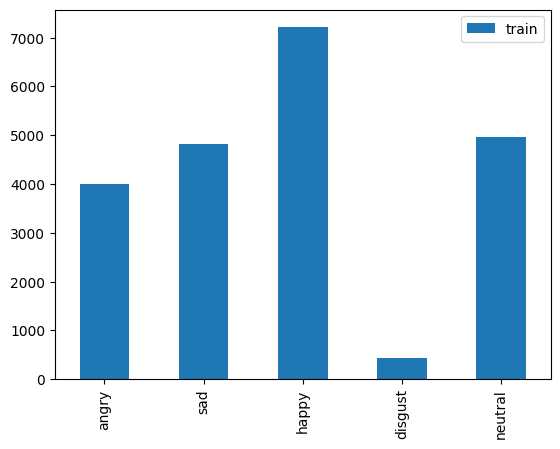

In [10]:
train_count.transpose().plot(kind='bar')


<Axes: >

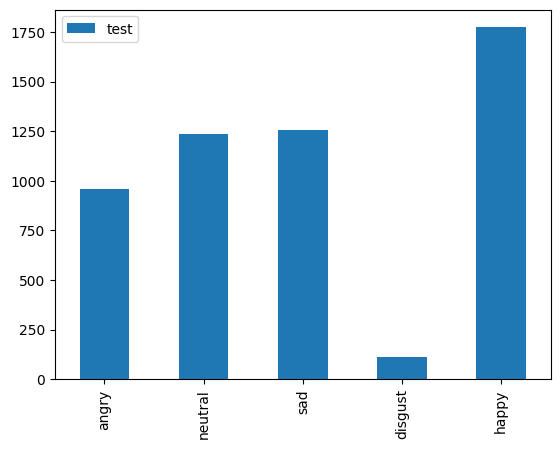

In [11]:
test_count.transpose().plot(kind='bar')


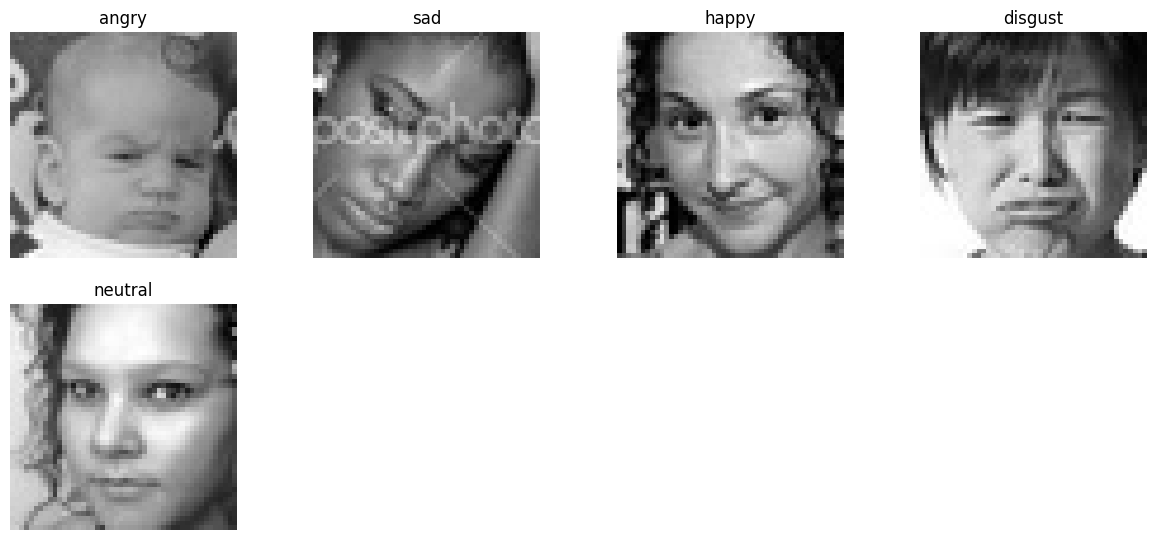

In [12]:
emotions=os.listdir(train_dir)
plt.figure(figsize=(15,10))
for i,emotion in enumerate(emotions,1):
    folder=os.path.join(train_dir,emotion)
    img_path=os.path.join(folder,os.listdir(folder)[10])
    img=plt.imread(img_path)
    plt.subplot(3,4,i)
    plt.imshow(img,cmap='gray')
    plt.title(emotion)
    plt.axis('off')

In [15]:
train_data_dir='dataset/train'
test_data_dir='dataset/test'

In [16]:
img_width,img_height=224,224
batch_size=32
epochs=15
num_classes=5

In [17]:
data_generator = ImageDataGenerator(
    rescale=1./255,  # Rescale the pixel values from [0, 255] to [0, 1]
    rotation_range=40,  # Degree range for random rotations
    width_shift_range=0.2,  # Range (as a fraction of total width) for random horizontal shifts
    height_shift_range=0.2,  # Range (as a fraction of total height) for random vertical shifts
    shear_range=0.2,  # Shearing intensity (shear angle in counter-clockwise direction)
    zoom_range=0.2,  # Range for random zoom
    horizontal_flip=True,  # Randomly flip inputs horizontally
    fill_mode='nearest',  # Strategy to fill newly created pixels, which can appear after a rotation or a width/height shift
    validation_split=0.2  # Set the validation split; 20% of the data will be used for validation
)

In [18]:
test_data_generator=ImageDataGenerator(rescale=1./255)

train_generator=data_generator.flow_from_directory(
train_data_dir,
target_size=(img_width,img_height),
batch_size=batch_size,
class_mode='categorical',
color_mode='rgb')

test_generator=test_data_generator.flow_from_directory(
test_data_dir,
target_size=(img_width,img_height),
batch_size=batch_size,
class_mode='categorical',
color_mode='rgb')

Found 21441 images belonging to 5 classes.
Found 5333 images belonging to 5 classes.


In [19]:
# Extract class labels for all instances in the training dataset
classes = np.array(train_generator.classes)

# Calculate class weights to handle imbalances in the training data
# 'balanced' mode automatically adjusts weights inversely proportional to class frequencies
class_weights = compute_class_weight(
    class_weight='balanced',  # Strategy to balance classes
    classes=np.unique(classes),  # Unique class labels
    y=classes  # Class labels for each instance in the training dataset
)

# Create a dictionary mapping class indices to their calculated weights
class_weights_dict = dict(enumerate(class_weights))

# Output the class weights dictionary
print("Class Weights Dictionary:", class_weights_dict)

Class Weights Dictionary: {0: 1.0733917396745933, 1: 9.835321100917431, 2: 0.5943451143451144, 3: 0.8636858006042296, 4: 0.8878260869565218}


In [20]:
train_generator.class_indices


{'angry': 0, 'disgust': 1, 'happy': 2, 'neutral': 3, 'sad': 4}

In [21]:
ResNet =ResNet50V2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
ResNet.summary()

94668760/94668760 [==============================] - 1s 0us/step
Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                        

In [22]:
ResNet.trainable=True


In [23]:
for layer in ResNet.layers[:-50]:
    layer.trainable = False

ResNet.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                         

In [24]:
x = Flatten()(ResNet.output)


x = Dense(512, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization

# Adding the output layer with softmax activation
# Note: Adjust the number of units to match the number of classes you have
output = Dense(5, activation='softmax', kernel_initializer='he_normal')(x)

# Creating the model
model = Model(inputs=ResNet.input, outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

# Model summary to see all layers
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                              

In [25]:
cnn_path=r'Emotion_Detection/ResNet50'
name='ResNet_model.keras'
chk_path=os.path.join(cnn_path,name)
chk_path

'Emotion_Detection/ResNet50/ResNet_model.keras'

In [26]:
checkpoint=ModelCheckpoint(filepath=chk_path,
                          save_best_only=True,
                          verbose=1,
                           mode='min',
                          monitor='val_loss')

In [27]:
earlystop=EarlyStopping(monitor='val_loss',
                       patience=3,
                       verbose=1,
                       min_delta=0,
                       restore_best_weights=True)

In [28]:
reduce_lr=ReduceLROnPlateau(monitor='val_loss',
                       factor=0.2,
                       patience=6,
                       verbose=1,
                       min_delta=0.01)

In [29]:
csv_logger=CSVLogger(os.path.join(cnn_path,'training.log'))

In [30]:
callbacks=[checkpoint,earlystop,reduce_lr,csv_logger]


In [31]:
train_generator.samples


21441

In [32]:
history=model.fit(train_generator,epochs=50,validation_data=test_generator,class_weight=class_weights_dict,callbacks=callbacks)


Epoch 1/50
671/671 [==============================] - ETA: 0s - loss: 1.5980 - accuracy: 0.3882
Epoch 1: val_loss improved from inf to 1.08987, saving model to Emotion_Detection/ResNet50/ResNet_model.keras
671/671 [==============================] - 1869s 3s/step - loss: 1.5980 - accuracy: 0.3882 - val_loss: 1.0899 - val_accuracy: 0.5732 - lr: 1.0000e-04
Epoch 2/50
671/671 [==============================] - ETA: 0s - loss: 1.2476 - accuracy: 0.5031
Epoch 2: val_loss improved from 1.08987 to 1.00508, saving model to Emotion_Detection/ResNet50/ResNet_model.keras
671/671 [==============================] - 422s 629ms/step - loss: 1.2476 - accuracy: 0.5031 - val_loss: 1.0051 - val_accuracy: 0.6047 - lr: 1.0000e-04
Epoch 3/50
671/671 [==============================] - ETA: 0s - loss: 1.1491 - accuracy: 0.5465
Epoch 3: val_loss improved from 1.00508 to 0.91566, saving model to Emotion_Detection/ResNet50/ResNet_model.keras
671/671 [==============================] - 447s 666ms/step - loss: 1.149

In [35]:
model.save("ResNet50")

In [36]:
import tensorflow
model=tensorflow.keras.models.load_model("ResNet50.h5")

In [37]:
def plot_training_history(history):
    """
    Plots the training and validation accuracy and loss.

    Parameters:
    - history: A Keras History object. Contains the logs from the training process.

    Returns:
    - None. Displays the matplotlib plots for training/validation accuracy and loss.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(20, 5))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

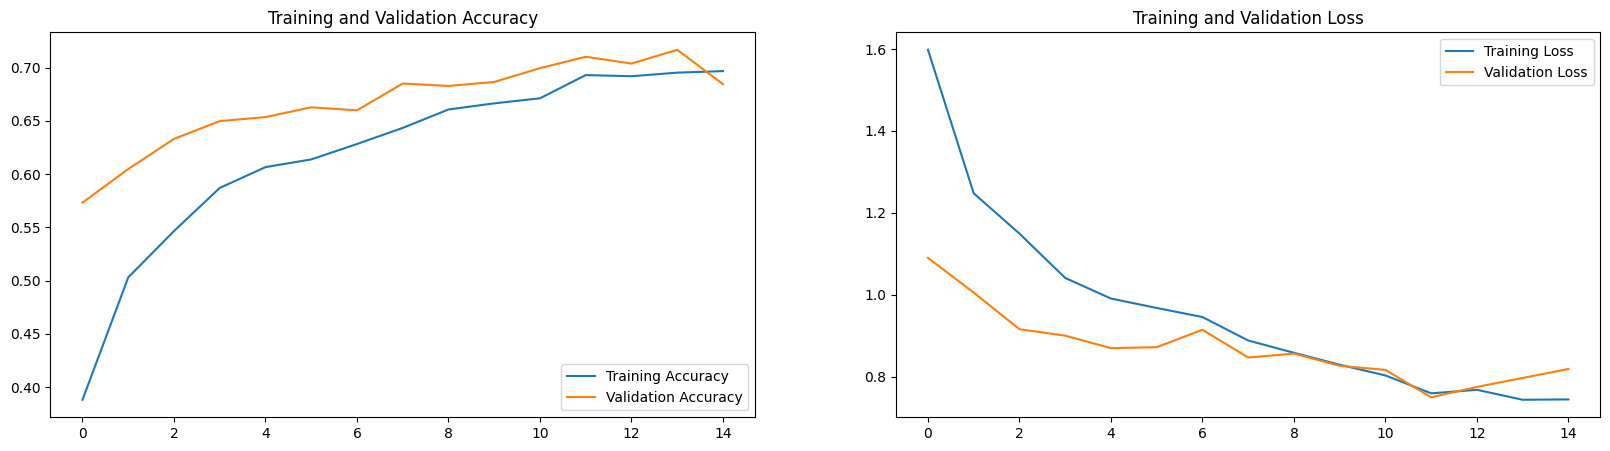

In [38]:
plot_training_history(history)


In [39]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

167/167 [==============================] - 24s 144ms/step - loss: 0.7493 - accuracy: 0.7101
final train accuracy = 72.40 , validation accuracy = 71.01


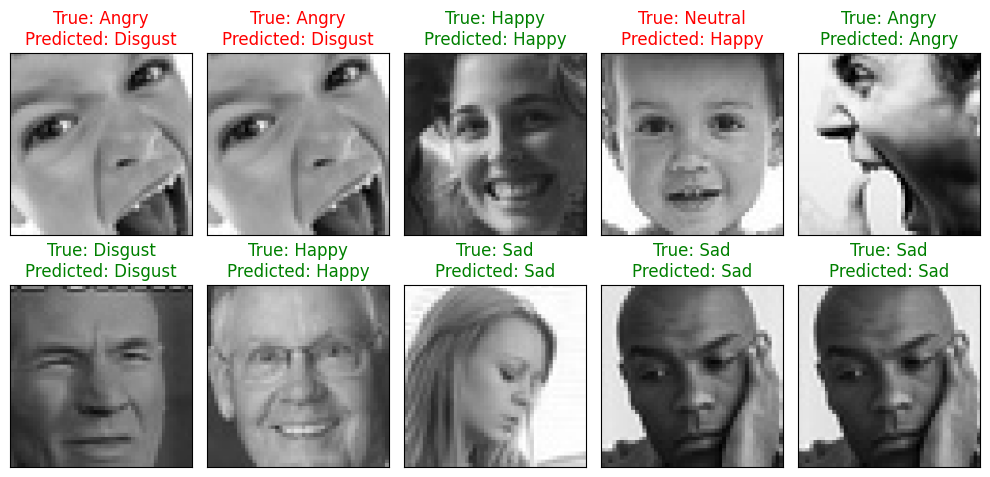

In [45]:
# Emotion classes for the dataset
Emotion_Classes = ['Angry', 'Disgust', 'Happy', 'Neutral', 'Sad']

# Assuming test_generator and model are already defined
batch_size = test_generator.batch_size

# Selecting a random batch from the test generator
Random_batch = np.random.randint(0, len(test_generator) - 1)

# Selecting random image indices from the batch
Random_Img_Index = np.random.randint(0, batch_size, 10)

# Setting up the plot
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    # Fetching the random image and its label
    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]], axis=0)

    # Making a prediction using the model
    Model_Prediction = np.argmax(model.predict(tf.expand_dims(Random_Img, axis=0), verbose=0), axis=1)[0]

    # Displaying the image
    ax.imshow(Random_Img.squeeze(), cmap='gray')  # Assuming the images are grayscale
    # Setting the title with true and predicted labels, colored based on correctness
    color = "green" if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction] else "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()